## Identify the "start of climate change" 
The algorithm is as follows, applied to a variable (Y):

1. Identify inflection (T0) point as "start of climate change": point where dY/dt != 0 for remainder of record
2. Compute trend (ω) from that point forward
3. Compute ToE as a timescale: ToE = 2 σ / ω
4. Year of detection = T0 + ToE

In [3]:
from itertools import product

import numpy as np
import xarray as xr
from scipy import integrate
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import util
plt.style.use('ggplot')

In [2]:
import statsmodels

In [4]:
variables = ['SST', 'Chl_surf', 'KGP']

ds_djf = xr.open_zarr('data/cesm-le-djf-triregion-timeseries.zarr')
ds_djf = ds_djf[variables].sel(length = 40).sel(region = 'Southern Ocean')
ds_djf


<xarray.Dataset>
Dimensions:    (member_id: 34, time: 180)
Coordinates:
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
    region     <U17 'Southern Ocean'
    length     float64 40.0
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
Data variables:
    SST        (time, member_id) float64 dask.array<chunksize=(180, 34), meta=np.ndarray>
    Chl_surf   (time, member_id) float64 dask.array<chunksize=(180, 34), meta=np.ndarray>
    KGP        (time, member_id) float64 dask.array<chunksize=(90, 34), meta=np.ndarray>

## Compute the properties of the unperturbed climate

The mean

In [5]:
ds_ref_mean = (
        ds_djf.sel(time=slice(1920, 1950))
        .mean(dim=['time', 'member_id'])
        .compute()
)
#ds_ref_mean

Standard deviation of anomalies

In [6]:
ds_ref_std = (
        (ds_djf - ds_djf.mean(dim=['member_id']).sel(time=slice(1920, 1950)))
        .std(dim=['time', 'member_id'])
        .compute()
)
#ds_ref_std

### calculate and plot the anomalies relative to the reference

In [7]:
forced = ds_djf.mean('member_id')     
anom_f = forced - ds_ref_mean
#anom_f

Text(0.5, 1.0, 'Daily growth rate anomaly ')

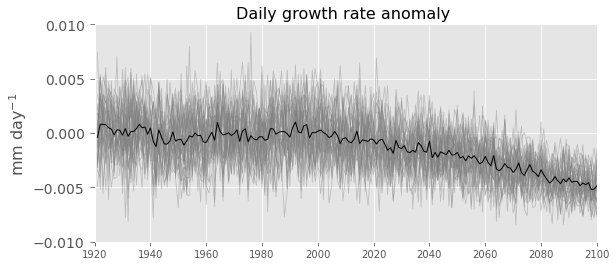

In [8]:
v = 'KGP'
###########   As a Plot  ##############
gs = gridspec.GridSpec(1,1)
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
limYMin, limYMax = -0.01, 0.01
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf.member_id:
    var_i = ds_djf[v].sel(member_id=m_id)
    ref_i = ds_djf[v].sel(member_id=m_id).sel(time=slice('1920', '1950')).mean(['time'])
    anom = var_i - ref_i
    ax.plot(ds_djf.time, anom,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ax.plot(ds_djf.time, anom_f[v],'-', linewidth=1, color='k')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title(f'{ds_djf[v].long_name} anomaly ', fontsize = 16)

## Calculate cumulative integrals

In [9]:
x = anom_f['time'] # The coordinate to integrate along.

# Cumulatively integrate mm day(years) using the composite trapezoidal rule.
y_k = anom_f['KGP'].values # Values to integrate.
y_int_k = xr.full_like(anom_f['KGP'], fill_value=0)
y_int_k.values = integrate.cumtrapz(y_k, x, initial=0)

y_t = anom_f['SST'].values # Values to integrate.
y_int_t = xr.full_like(anom_f['SST'], fill_value=0)
y_int_t.values = integrate.cumtrapz(y_t, x, initial=0)

y_c = anom_f['Chl_surf'].values # Values to integrate.
y_int_c = xr.full_like(anom_f['Chl_surf'], fill_value=0)
y_int_c.values = integrate.cumtrapz(y_c, x, initial=0)

### ID Inflection Point

In [10]:
# Isolate the climate change signal
x = anom_f['time'] # The coordinate to integrate along.
for l in range(len(x)): # krill
    if all(y_int_k[l:] < 0):
        ndx_k = l
        break
#krill        
x_cc_k = x[ndx_k:]
y_cc_k = y_int_k[ndx_k:]
beta_k = np.polyfit(x_cc_k, y_cc_k, 1)
bf_k = beta_k[1] + beta_k[0]*x_cc_k
        
for l in range(len(x)): # chlorophyll
    if all(y_int_c[l:] < 0):
        ndx_c = l
        break

#chlorophyll        
x_cc_c = x[ndx_c:]
y_cc_c = y_int_c[ndx_c:]
beta_c = np.polyfit(x_cc_c, y_cc_c, 1)
bf_c = beta_c[1] + beta_c[0]*x_cc_c

for l in range(len(x)): # temp
    if all(y_int_t[l:] > 0):
        ndx_t = l    
        break
#sst        
x_cc_t = x[ndx_t:]
y_cc_t = y_int_t[ndx_t:]
beta_t = np.polyfit(x_cc_t, y_cc_t, 1)
bf_t = beta_t[1] + beta_t[0]*x_cc_t

# #TEST
# plt.figure(figsize=(15, 4))
# plt.plot(x, y_int_k)
# plt.plot(x_cc_k, y_cc_k, 'o')
# plt.plot(x_cc_k, bf_k, 'g-')

### Check by plotting

ValueError: x and y must have same first dimension, but have shapes (149,) and (180,)

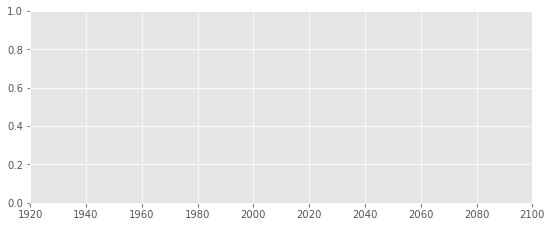

In [41]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3,1)
#####################################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
#ax.set_ylim([-.05, .025])
ax.plot(x, y_int_k, color = 'C0', linewidth = 2) # full time series
ax.plot(x_cc_k, y_cc_k, color = 'k', linestyle=':') # post climate change
ax.plot(x_cc_k, bf_k, '--k', alpha = .5) #best fit line
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .5)
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = 'cumulative integral of anomalies relative to the reference'
ax.set_title(title, fontsize = 16);
#####################################
ax = fig.add_subplot(gs[1, 0])
ax.set_xlim((1920, 2100))
#ax.set_ylim([-2, .5])
ax.plot(x, y_int_c, color = 'C1', linewidth = 2) # full time series
ax.plot(x_cc_c, y_cc_c, color = 'k', linestyle=':') # post climate change
ax.plot(x_cc_c, bf_c, '--k', alpha = .5) #best fit line
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .5)
ax.set_ylabel('mg m$^3$', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title('Chl anomaly cumulative integral', fontsize = 16)
#####################################
ax = fig.add_subplot(gs[2, 0])
ax.set_xlim((1920, 2100))
ax.set_xlabel(' ', fontsize = 2)
#ax.set_ylim([-1, 3])
ax.plot(x, y_int_t, color = 'C2', linewidth = 2)
ax.plot(x_cc_t, y_cc_t, color = 'k', linestyle=':')
ax.plot(x_cc_t, bf_t, '--k', alpha = .5) #best fit line
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .5)
ax.set_ylabel('°C', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title('SST anomaly cumulative integral', fontsize = 16)
#####################################
gs.update(hspace=.2, top=.92, right =1)

# title = ('cumulative integrals ')
# path = 'figures/'
# file = '.pdf'
# plt.savefig(path + title + file, bbox_inches='tight')

The idea here is that you're looking for a representation of the force trend. Which gives you a magnitude of quantity per time and then you divide the standard deviation by that quantity per time, and you're left with time.

* t * t sigma / by the trend gives you a time scale.
    * 2sigma / mean = timescale
* Time the year of detection is T naught plus t o.
    * tnaught + toe


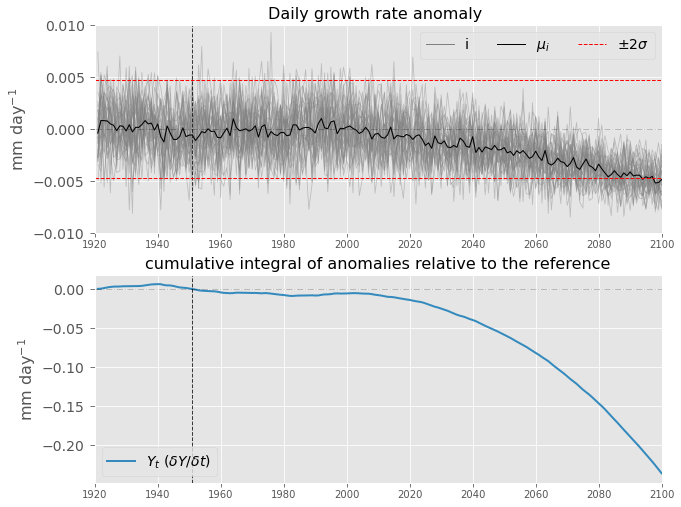

In [12]:
v = 'KGP'
###########   As a Plot  ##############
gs = gridspec.GridSpec(2,1)
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
limYMin, limYMax = -0.01, 0.01
#~~~~~~~~~~~~    CESM-LE Anomalies   ~~~~~~~~~
for m_id in ds_djf.member_id:
    var_i = ds_djf[v].sel(member_id=m_id)
    ref_i = ds_djf[v].sel(member_id=m_id).sel(time=slice('1920', '1950')).mean(['time'])
    anom = var_i - ref_i
    ax.plot(ds_djf.time, anom, '-', linewidth=0.8, color = 'grey', alpha = 0.4)
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .25)
ax.axvline(y_cc_k.time[0], lw=1, color='k', linestyle='--', alpha = .75)

ax.plot(ds_djf.time, anom_f[v],'-', linewidth=1, color='grey', label = 'i') # fake for sake of legend
ax.plot(ds_djf.time, anom_f[v],'-', linewidth=1, color='k', label = '$\mu_i$')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref = ds_djf[v].sel(time=slice('1920', '1950')).mean(['member_id', 'time'])

ax.axhline((ds_ref_mean[v]-ref) + 2 * ds_ref_std[v], 
           lw=1, color='r', linestyle='--') # positive two sigma
ax.axhline((ds_ref_mean[v]-ref) - 2 * ds_ref_std[v], 
           lw=1, color='r', linestyle='--', label = '$\pm2\sigma$') # negative two sigma
# ax.plot(ds_toe[v], ds_2sigma[v].sel(time=ds_toe[v])-ref, 'r*', color= 'purple', markersize=15)
ax.legend(ncol = 3, fontsize = 14)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title(f'{ds_djf[v].long_name} anomaly ', fontsize = 16)
#~~~~~~~~~~~~    Cumulative Integral   ~~~~~~~~~
ax = fig.add_subplot(gs[1, 0])
ax.set_xlim((1920, 2100))
ax.plot(x, y_int_k, color = 'C1', linewidth = 2, label = '$Y_t$ ($\delta Y/ \delta t$)') # full time series
ax.axvline(y_cc_k.time[0], lw=1, color='k', linestyle='--', alpha = .75)
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .25)
ax.legend(loc = 'lower left', ncol = 3, fontsize = 14)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = 'cumulative integral of anomalies relative to the reference'
ax.set_title(title, fontsize = 16);

gs.update(hspace=.2, top=.92, right=1)

## Regression analysis
A generalized least-squares model with a ﬁrst-order autoregressive error term (AR(1)) was applied to time series of the annual maxima (SST) or minima (other variables) using R package ‘nlme’ 72 :

In [45]:
kgp_yr = 1951
chl_yr = 2006
sst_yr = 1950

In [51]:
x = ds_djf['time'] # The coordinate to integrate along.
x = x[kgp_yr-1920:]
x

<xarray.DataArray 'time' (time: 149)>
array([1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
       2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023,
       2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035,
       2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047,
       2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059,
       2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071,
       2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083,
       2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095,
       2096, 2097, 2098, 2099, 2100])
Coordinates:
  * time     (time) int64 1952 1953 1954 1955 1956 ... 2096 2097 2098 2099 2100
    region   <U17 'Southern Ocean'
    length   float64 40.0

In [52]:
# y = anom_f['KGP'].values[kgp_yr-1920:]
# y
y = anom_f['KGP']
y = y[kgp_yr-1920:]
y

<xarray.DataArray 'KGP' (time: 149)>
dask.array<getitem, shape=(149,), dtype=float64, chunksize=(90,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 1952 1953 1954 1955 1956 ... 2096 2097 2098 2099 2100
    region   <U17 'Southern Ocean'
    length   float64 40.0

In [53]:
beta_k = np.polyfit(x, y, 1)
beta_k

array([-3.43088907e-05,  6.79134555e-02])

In [55]:
bf_k = beta_k[1] + beta_k[0]*x
bf_k

<xarray.DataArray 'time' (time: 149)>
array([ 9.42500815e-04,  9.08191924e-04,  8.73883034e-04,  8.39574143e-04,
        8.05265252e-04,  7.70956361e-04,  7.36647471e-04,  7.02338580e-04,
        6.68029689e-04,  6.33720798e-04,  5.99411908e-04,  5.65103017e-04,
        5.30794126e-04,  4.96485235e-04,  4.62176345e-04,  4.27867454e-04,
        3.93558563e-04,  3.59249672e-04,  3.24940782e-04,  2.90631891e-04,
        2.56323000e-04,  2.22014109e-04,  1.87705219e-04,  1.53396328e-04,
        1.19087437e-04,  8.47785465e-05,  5.04696557e-05,  1.61607650e-05,
       -1.81481258e-05, -5.24570165e-05, -8.67659072e-05, -1.21074798e-04,
       -1.55383689e-04, -1.89692579e-04, -2.24001470e-04, -2.58310361e-04,
       -2.92619252e-04, -3.26928142e-04, -3.61237033e-04, -3.95545924e-04,
       -4.29854815e-04, -4.64163705e-04, -4.98472596e-04, -5.32781487e-04,
       -5.67090378e-04, -6.01399268e-04, -6.35708159e-04, -6.70017050e-04,
       -7.04325941e-04, -7.38634831e-04, -7.72943722e-04, -8.07252613e-04,
       -8.41561504e-04, -8.75870394e-04, -9.10179285e-04, -9.44488176e-04,
       -9.78797067e-04, -1.01310596e-03, -1.04741485e-03, -1.08172374e-03,
       -1.11603263e-03, -1.15034152e-03, -1.18465041e-03, -1.21895930e-03,
       -1.25326819e-03, -1.28757708e-03, -1.32188597e-03, -1.35619486e-03,
       -1.39050376e-03, -1.42481265e-03, -1.45912154e-03, -1.49343043e-03,
       -1.52773932e-03, -1.56204821e-03, -1.59635710e-03, -1.63066599e-03,
       -1.66497488e-03, -1.69928377e-03, -1.73359266e-03, -1.76790155e-03,
       -1.80221044e-03, -1.83651934e-03, -1.87082823e-03, -1.90513712e-03,
       -1.93944601e-03, -1.97375490e-03, -2.00806379e-03, -2.04237268e-03,
       -2.07668157e-03, -2.11099046e-03, -2.14529935e-03, -2.17960824e-03,
       -2.21391713e-03, -2.24822602e-03, -2.28253491e-03, -2.31684381e-03,
       -2.35115270e-03, -2.38546159e-03, -2.41977048e-03, -2.45407937e-03,
       -2.48838826e-03, -2.52269715e-03, -2.55700604e-03, -2.59131493e-03,
       -2.62562382e-03, -2.65993271e-03, -2.69424160e-03, -2.72855049e-03,
       -2.76285939e-03, -2.79716828e-03, -2.83147717e-03, -2.86578606e-03,
       -2.90009495e-03, -2.93440384e-03, -2.96871273e-03, -3.00302162e-03,
       -3.03733051e-03, -3.07163940e-03, -3.10594829e-03, -3.14025718e-03,
       -3.17456607e-03, -3.20887496e-03, -3.24318386e-03, -3.27749275e-03,
       -3.31180164e-03, -3.34611053e-03, -3.38041942e-03, -3.41472831e-03,
       -3.44903720e-03, -3.48334609e-03, -3.51765498e-03, -3.55196387e-03,
       -3.58627276e-03, -3.62058165e-03, -3.65489054e-03, -3.68919944e-03,
       -3.72350833e-03, -3.75781722e-03, -3.79212611e-03, -3.82643500e-03,
       -3.86074389e-03, -3.89505278e-03, -3.92936167e-03, -3.96367056e-03,
       -3.99797945e-03, -4.03228834e-03, -4.06659723e-03, -4.10090612e-03,
       -4.13521501e-03])
Coordinates:
  * time     (time) int64 1952 1953 1954 1955 1956 ... 2096 2097 2098 2099 2100
    region   <U17 'Southern Ocean'
    length   float64 40.0

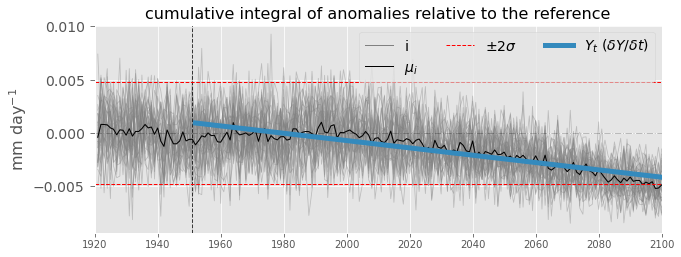

In [57]:
v = 'KGP'
###########   As a Plot  ##############
gs = gridspec.GridSpec(2,1)
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
limYMin, limYMax = -0.01, 0.01
#~~~~~~~~~~~~    CESM-LE Anomalies   ~~~~~~~~~
for m_id in ds_djf.member_id:
    var_i = ds_djf[v].sel(member_id=m_id)
    ref_i = ds_djf[v].sel(member_id=m_id).sel(time=slice('1920', '1950')).mean(['time'])
    anom = var_i - ref_i
    ax.plot(ds_djf.time, anom, '-', linewidth=0.8, color = 'grey', alpha = 0.4)
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .25)
ax.axvline(y_cc_k.time[0], lw=1, color='k', linestyle='--', alpha = .75)

ax.plot(ds_djf.time, anom_f[v],'-', linewidth=1, color='grey', label = 'i') # fake for sake of legend
ax.plot(ds_djf.time, anom_f[v],'-', linewidth=1, color='k', label = '$\mu_i$')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref = ds_djf[v].sel(time=slice('1920', '1950')).mean(['member_id', 'time'])

ax.axhline((ds_ref_mean[v]-ref) + 2 * ds_ref_std[v], 
           lw=1, color='r', linestyle='--') # positive two sigma
ax.axhline((ds_ref_mean[v]-ref) - 2 * ds_ref_std[v], 
           lw=1, color='r', linestyle='--', label = '$\pm2\sigma$') # negative two sigma
# ax.plot(ds_toe[v], ds_2sigma[v].sel(time=ds_toe[v])-ref, 'r*', color= 'purple', markersize=15)

ax.plot(x, bf_k, color = 'C1', linewidth = 5, label = '$Y_t$ ($\delta Y/ \delta t$)') # full time series


ax.legend(ncol = 3, fontsize = 14)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = 'cumulative integral of anomalies relative to the reference'
ax.set_title(title, fontsize = 16);

gs.update(hspace=.2, top=.92, right=1)

In [15]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [24]:
lr.fit(x, y)


ValueError: Expected 2D array, got 1D array instead:
array=[1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934
 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032
 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046
 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060
 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074
 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088
 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

$Y_t = \mu + \omega + N_t$
* $Y_t$ = the annual extreme in the variable
* $t$ = the linear trend function (time in years)
* $\mu$ = a constant term (the intercept)
* $\omega$ = is the magnitude of the trend (the slope)
* $N_t$ = unexplained portion of the data modelled as an AR(1) process


Trends for SST are reported as °C per decade;
Trends for PP, pH and oxygen as the % change per decade with respect to the mean of 1986–2005. 

The assumption of normality in the annual extrema was checked using the Lilliefors test. 

Approximately 80% of pixels pass the test for pH and SST, and B65% for PP and oxygen. The majority of pixels failing these tests are in the Arctic.

In [28]:
y_cc_t.time[0].compute

<bound method DataArray.compute of <xarray.DataArray 'time' ()>
array(1950)
Coordinates:
    time     int64 1950
    region   <U17 'Southern Ocean'
    length   float64 40.0>

In [ ]:
%%time
# set up trend dimensions
trend_year = xr.DataArray(np.arange(1925, 2101, 1), dims=('time'))
trend_length = xr.DataArray([5, 10, 20, 60], dims=('trend_length'))

# loop over trends
ds_list = []
for end_year, n_year in product(trend_year.values, trend_length.values):

    # subset data for the time-period of this trend
    ds = ds_djf_regional.sel(time=slice(end_year-n_year+1, end_year))
    if len(ds.time) != n_year: 
        continue
        
    # loop over vars and compute trends
    da_list = []
    for v in ds.data_vars:
        da = util.linear_trend(
            ds[v]
        ).expand_dims(
            trend_length=[n_year], 
            trend_year=[end_year]
        ) * 10.
        da.attrs = ds[v].attrs
        da.attrs['units'] = ds[v].units + ' decade$^{-1}$'
        da_list.append(da)
        
    ds_list.append(xr.merge(da_list))
    
ds_djf_rgn_trnd = xr.combine_by_coords(ds_list).compute()
ds_djf_rgn_trnd

In [19]:
#subset data for the time-period of this trend
ds_cc = ds_djf.sel(time=slice(y_cc_k.time[0], 2021))
ds_cc

<xarray.Dataset>
Dimensions:    (member_id: 34, time: 71)
Coordinates:
  * time       (time) int64 1951 1952 1953 1954 1955 ... 2018 2019 2020 2021
    region     <U17 'Southern Ocean'
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
    length     float64 40.0
Data variables:
    SST        (time, member_id) float64 dask.array<chunksize=(71, 34), meta=np.ndarray>
    Chl_surf   (time, member_id) float64 dask.array<chunksize=(71, 34), meta=np.ndarray>
    KGP        (time, member_id) float64 dask.array<chunksize=(60, 34), meta=np.ndarray>

In [22]:
# loop over vars and compute trends
da_list = []
for v in ds_cc.data_vars:
    da = util.linear_trend(
        ds_cc[v])
    da.attrs = ds_cc[v].attrs
    da_list.append(da)
        
da_list

[<xarray.DataArray 'SST' (member_id: 34)>
 dask.array<vectorize_calc_slope, shape=(34,), dtype=float64, chunksize=(34,), chunktype=numpy.ndarray>
 Coordinates:
     region     <U17 'Southern Ocean'
   * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
     length     float64 40.0
 Attributes:
     cell_methods:  time: mean
     grid_loc:      3111
     long_name:     Potential Temperature
     units:         degC,
 <xarray.DataArray 'Chl_surf' (member_id: 34)>
 dask.array<vectorize_calc_slope, shape=(34,), dtype=float64, chunksize=(34,), chunktype=numpy.ndarray>
 Coordinates:
     region     <U17 'Southern Ocean'
   * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
     length     float64 40.0
 Attributes:
     cell_methods:  time: mean
     grid_loc:      3114
     long_name:     Surface chlorophyll
     units:         mg/m^3,
 <xarray.DataArray 'KGP' (member_id: 34)>
 dask.array<vectorize_calc_slope, shape=(34,), dtype=float64,

In [ ]:
ds_cc_trnd = xr.combine_by_coords(ds_list).compute()
ds_cc_trnd